**問題１**

In [11]:
!apt-get -y install fonts-ipafont-gothic


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# IPAフォントのパスを取得
font_path = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'

# フォントプロパティを作成
font_prop = fm.FontProperties(fname=font_path)

# フォント設定の更新
plt.rc('font', family=font_prop.get_name())


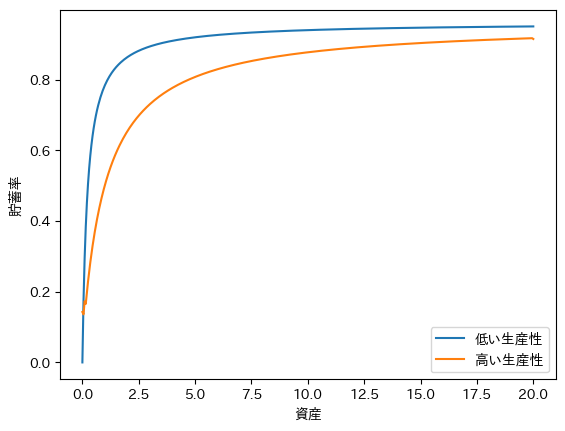

In [13]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space

def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['alpha'] = alpha
    param['delta'] = delta

    return param

def solve_household(param, r, w):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)

    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]

    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

def get_distribution(param, decisions):
    NA = param['NA']
    NH = param['NH']
    iaplus = decisions[1]
    pi = param['pi']

    test = 10
    phi = np.ones((NA, NH))/NA/NH

    while test > 1e-8:
        phi_new = np.zeros((NA, NH))
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]

        test = np.max(np.abs(phi_new - phi))
        phi = phi_new

    return phi

# パラメータの設定
r = 0.04
w = 1
param = setPar()

# 家計問題の解法
decisions = solve_household(param, r, w)
aplus = decisions[0]
c = decisions[2]

# グリッドの設定
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# 貯蓄率のプロット
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='低い生産性')
plt.xlabel("資産")
plt.ylabel("貯蓄率")

plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='高い生産性')
plt.xlabel("資産")
plt.ylabel("貯蓄率")

plt.legend()
plt.show()


**問題２**

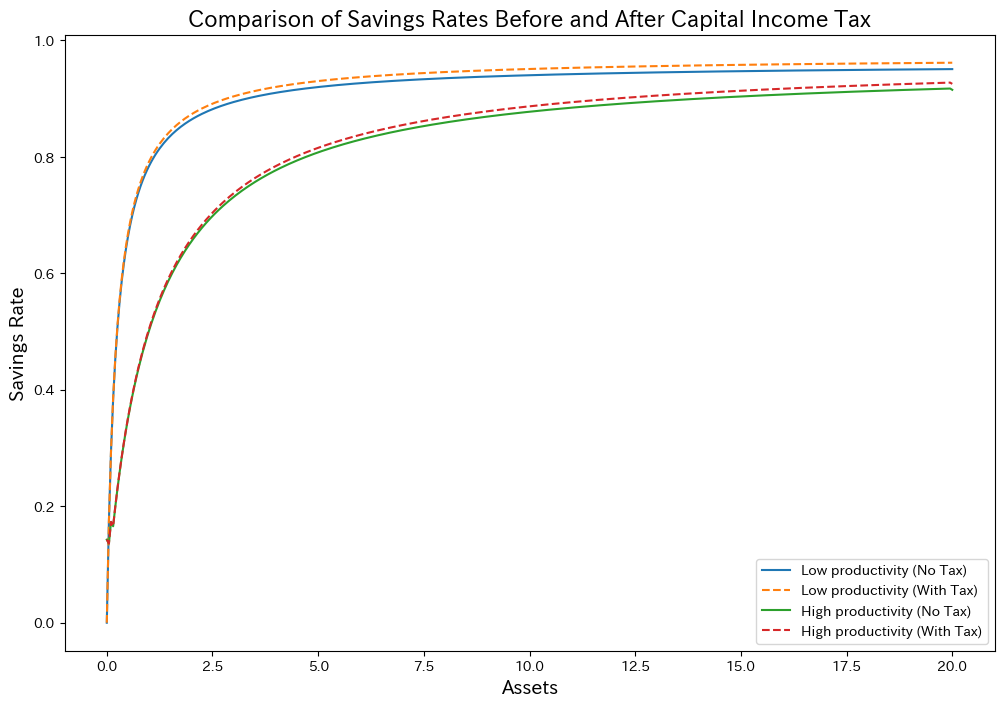

In [15]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space

def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['alpha'] = alpha
    param['delta'] = delta

    return param

def solve_household(param, r, w, tau_k=0):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)

    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + (1.0 - tau_k)*r)*a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]

    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + (1.0 - tau_k)*r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

# パラメータの設定
r = 0.04
w = 1
param = setPar()

# 家計問題の解法
decisions_no_tax = solve_household(param, r, w)
aplus_no_tax = decisions_no_tax[0]
c_no_tax = decisions_no_tax[2]

# 資本所得税（tau_k = 0.3）の場合の家計問題の解法
tau_k = 0.3
decisions_with_tax = solve_household(param, r, w, tau_k)
aplus_with_tax = decisions_with_tax[0]
c_with_tax = decisions_with_tax[2]

# グリッドの設定
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# 貯蓄率のプロット
plt.figure(figsize=(12, 8))
plt.plot(a, aplus_no_tax[:, 0]/(c_no_tax[:, 0] + aplus_no_tax[:, 0]), label='Low productivity (No Tax)')
plt.plot(a, aplus_with_tax[:, 0]/(c_with_tax[:, 0] + aplus_with_tax[:, 0]), linestyle='--', label='Low productivity (With Tax)')
plt.plot(a, aplus_no_tax[:, 1]/(c_no_tax[:, 1] + aplus_no_tax[:, 1]), label='High productivity (No Tax)')
plt.plot(a, aplus_with_tax[:, 1]/(c_with_tax[:, 1] + aplus_with_tax[:, 1]), linestyle='--', label='High productivity (With Tax)')
plt.xlabel("Assets", fontsize=14)
plt.ylabel("Savings Rate", fontsize=14)
plt.legend()
plt.title("Comparison of Savings Rates Before and After Capital Income Tax", fontsize=16)
plt.show()


**問題３**

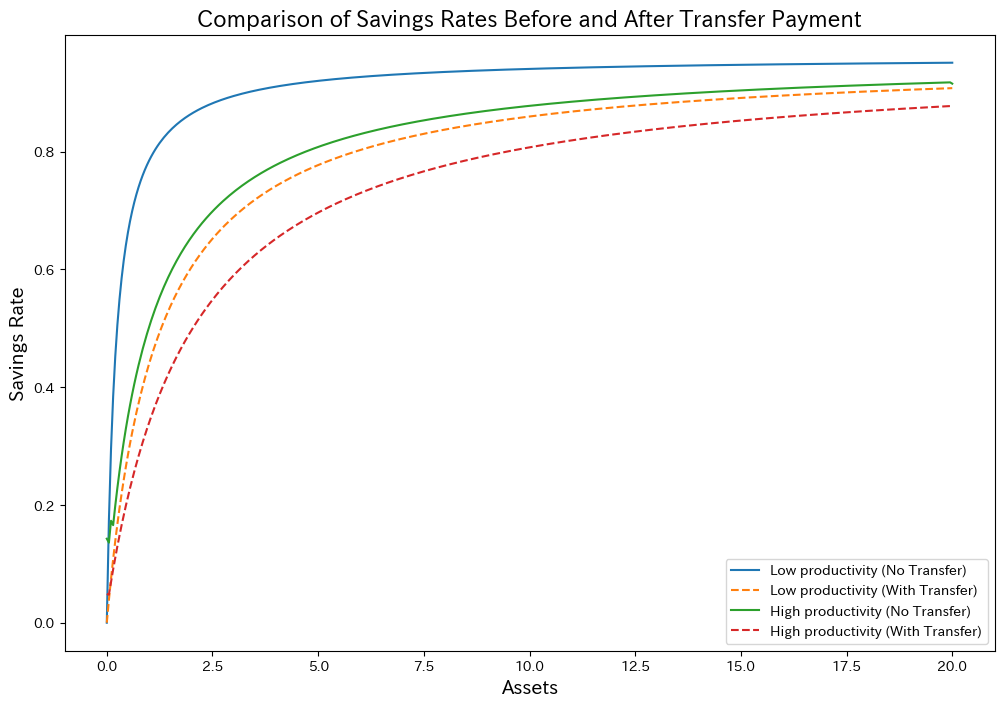

In [16]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space

def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['alpha'] = alpha
    param['delta'] = delta

    return param

def solve_household(param, r, w, T=0):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)

    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] + T - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]

    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] + T - aplus[ia, ih]

    return aplus, iaplus, c

# パラメータの設定
r = 0.04
w = 1
param = setPar()

# 家計問題の解法
decisions_no_tax = solve_household(param, r, w)
aplus_no_tax = decisions_no_tax[0]
c_no_tax = decisions_no_tax[2]

# 政府からの一括補助金 (T = 1) を導入した場合の家計問題の解法
T = 1
decisions_with_transfer = solve_household(param, r, w, T)
aplus_with_transfer = decisions_with_transfer[0]
c_with_transfer = decisions_with_transfer[2]

# グリッドの設定
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# 貯蓄率のプロット
plt.figure(figsize=(12, 8))
plt.plot(a, aplus_no_tax[:, 0]/(c_no_tax[:, 0] + aplus_no_tax[:, 0]), label='Low productivity (No Transfer)')
plt.plot(a, aplus_with_transfer[:, 0]/(c_with_transfer[:, 0] + aplus_with_transfer[:, 0]), linestyle='--', label='Low productivity (With Transfer)')
plt.plot(a, aplus_no_tax[:, 1]/(c_no_tax[:, 1] + aplus_no_tax[:, 1]), label='High productivity (No Transfer)')
plt.plot(a, aplus_with_transfer[:, 1]/(c_with_transfer[:, 1] + aplus_with_transfer[:, 1]), linestyle='--', label='High productivity (With Transfer)')
plt.xlabel("Assets", fontsize=14)
plt.ylabel("Savings Rate", fontsize=14)
plt.legend()
plt.title("Comparison of Savings Rates Before and After Transfer Payment", fontsize=16)
plt.show()


**問題４**

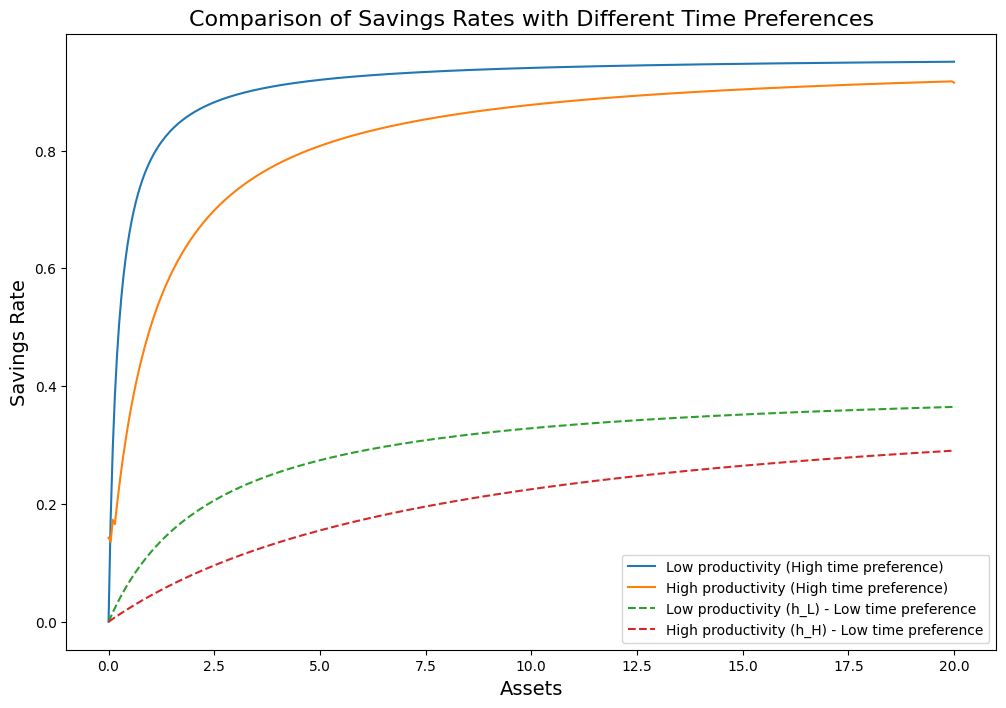

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# タウチェン法によるマルコフ過程の離散化
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, j] = 1.0 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# パラメータ設定
def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

# 家計問題の解法
def solve_household(param, r, w):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

# パラメータの設定
sigma = 1.5
beta_low = 0.1  # 低い時間選好率
rho = 0.6
sigma_e = 0.6
r = 0.04
w = 1

# 生産性の設定
h_L = np.exp(-sigma_e)
h_H = np.exp(sigma_e)

# 資産のグリッドを広範囲に設定
a_t_grid = np.linspace(0, 20, 200)

# 貯蓄率の計算（低い時間選好率）
def calc_saving_rate_low_beta(a_t, h):
    c_t = w * h + (1 + r) * a_t - a_t / (1 + beta_low)
    a_t_plus_1 = beta_low * (w * h + (1 + r) * a_t - c_t)
    saving_rate = a_t_plus_1 / (c_t + a_t_plus_1)
    return saving_rate

saving_rate_L_low_beta = [calc_saving_rate_low_beta(a, h_L) for a in a_t_grid]
saving_rate_H_low_beta = [calc_saving_rate_low_beta(a, h_H) for a in a_t_grid]

# 主要変数のプロット
def plot_results(aplus_high, c_high, aplus_low, c_low, a):
    plt.figure(figsize=(12, 8))
    plt.plot(a, aplus_high[:, 0] / (c_high[:, 0] + aplus_high[:, 0]), label='Low productivity (High time preference)', linestyle='-')
    plt.plot(a, aplus_high[:, 1] / (c_high[:, 1] + aplus_high[:, 1]), label='High productivity (High time preference)', linestyle='-')
    plt.plot(a_t_grid, saving_rate_L_low_beta, label='Low productivity (h_L) - Low time preference', linestyle='--')
    plt.plot(a_t_grid, saving_rate_H_low_beta, label='High productivity (h_H) - Low time preference', linestyle='--')
    plt.xlabel('Assets', fontsize=14)
    plt.ylabel('Savings Rate', fontsize=14)
    plt.legend()
    plt.title("Comparison of Savings Rates with Different Time Preferences", fontsize=16)
    plt.show()

# パラメータ設定（高い時間選好率）
param_high = setPar(beta=0.98)
# パラメータ設定（低い時間選好率）
param_low = setPar(beta=0.1)

# 金利と賃金の設定
r, w = 0.04, 1

# 家計問題の解法（高い時間選好率）
aplus_high, iaplus_high, c_high = solve_household(param_high, r, w)
# 家計問題の解法（低い時間選好率）
aplus_low, iaplus_low, c_low = solve_household(param_low, r, w)

# 結果のプロット
a = np.linspace(param_high['a_l'], param_high['a_u'], param_high['NA'])
plot_results(aplus_high, c_high, aplus_low, c_low, a)
